In [1]:
import sys
import gym
import pylab
import random
import numpy as np
from collections import deque
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

In [3]:
## Initialize important variables
env_name = 'CartPole-v1'
bRender = False
load_model = False

# Learning factors...
EPISODES = 200
discount_factor = 0.99
learning_rate = 0.001
epsilon = 1.0
epsilon_decay = 0.999
epsilon_min = 0.01
batch_size = 64
train_start = 1000

# create replay memory using deque
memory = deque(maxlen=2000)

# Create gym environment
env = gym.make(env_name)

state_size = env.observation_space.shape[0]
action_size = env.action_space.n

print(env.observation_space.shape)

(4,)


In [4]:
# The following function creates a neural network which is used as an 
# approximate Q function
# Input: state 
# Output: Q Value of each action
def build_model():
    model = Sequential()
    model.add(Dense(24, input_dim=state_size, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(24, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(action_size, activation='linear', kernel_initializer='he_uniform'))
    model.summary()
    model.compile(loss='mse', optimizer=Adam(learning_rate=learning_rate))
    return model


# create main model and target model
model = build_model()
target_model = build_model()


# if needed, one can load saved model
# if load_model == True:
#     model.load_weights("./cartpole_dqn.h5")
    

# after some time interval update the target model to be same with model
# This is done using the following function
def update_target_model():
    target_model.set_weights(model.get_weights())
    
# We call that function in the beginning to make sure model and target_model have the same weights initally
update_target_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 24)                120       
                                                                 
 dense_1 (Dense)             (None, 24)                600       
                                                                 
 dense_2 (Dense)             (None, 2)                 50        
                                                                 
Total params: 770
Trainable params: 770
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 24)                120       
                                                                 
 dense_4 (Dense)             (None, 

In [4]:
# We now define the main function of the DQN... please note that this is only a definition, we do not call it yet as 
# we are going to define some necessary complementary functions afterwards

def main():
    global epsilon
    
    # we want to save scores and episodes in lists....
    scores, episodes = [], []

    # we now play the defined number of episodes
    for e in range(EPISODES):
        done = False
        score = 0
        state = env.reset()
        print(state)
        # we need to reshape state for input to the neural network
        # state is of form:    [-0.01989946  0.18291444 -0.00080162 -0.29979175]
        # reshape is of form: [[-0.01989946  0.18291444 -0.00080162 -0.29979175]]
        state = np.reshape(state, [1, state_size])
                
        while not done:
            if bRender == True:
                env.render()

            # get action for the current state and go one step in environment
            action = get_action(state)
            next_state, reward, done, info = env.step(action)
            
            # state is of form:    [-0.01989946  0.18291444 -0.00080162 -0.29979175]
            # reshape is of form: [[-0.01989946  0.18291444 -0.00080162 -0.29979175]]
            next_state = np.reshape(next_state, [1, state_size])
            
            # if an action make the episode end, then gives penalty of -100 unless we reached 500 points / steps
            if done == True and score != 499:
                reward = -100
            
            # save the sample <s, a, r, s'> to the replay memory
            append_sample(state, action, reward, next_state, done)
            
            # every time step do the training
            train_model()
            # here reward is 1 per step, so we count score = number of steps game was playes
            score += reward
            state = next_state

            # if current game is over...
            if done:
                # every episode update the target model to be same with model
                update_target_model()

                # every episode, plot the play time
                score = score if score == 500 else score + 100
                scores.append(score)
                episodes.append(e)
                pylab.plot(episodes, scores, 'b')
                #pylab.savefig("./save_graph/cartpole_dqn.png")
                print("\r episode:", e, "  score:", score, "  memory length:", len(memory), "  epsilon:", epsilon)

                # if the mean of scores of last 10 episode is bigger than 490
                # stop training
                if np.mean(scores[-min(10, len(scores)):]) > 490:
                    sys.exit()

        # save the model every 50 episodes
        if e % 50 == 0:
            model.save_weights("./cartpole_dqn.h5")

In [5]:
# We now define all the complementary functions used above...        

# get action from model using epsilon-greedy policy
def get_action(state):
    if np.random.rand() <= epsilon:
        return random.randrange(action_size)
    else:
        # the model predicts a list of the type [[-1.1730378  1.5907776]]
        q_value = model.predict(state)
        # we return the action which has the higher Q value
        return np.argmax(q_value[0])

    
# save sample <s,a,r,s'> to the replay memory
def append_sample(state, action, reward, next_state, done):
    memory.append((state, action, reward, next_state, done))
    
    global epsilon
    # decay epsilon
    if epsilon > epsilon_min:
        epsilon *= epsilon_decay
        

# pick samples randomly from replay memory (with batch_size)
def train_model():
    
    global epsilon
    global batch_size
    global bNotificationStarted
    
    # only start training when memory is sufficiently full
    if len(memory) < train_start:
        return
    
    else:
        if bNotificationStarted == False:
            print("\n#############################################################################################")
            print("Memory sufficiently full, starting to train...")
            print("Please note: up to this point no learning happened at all, just random actions to fill memory")
            print("#############################################################################################" + "\n")
            bNotificationStarted = True
    
    # set batch_size (needed if batch_size > memory)
    batch_size = min(batch_size, len(memory))
    # sample a random mini_batch from memory
    mini_batch = random.sample(memory, batch_size)

    # we initialize the input and output as follows:
    # [[0. 0. 0. 0.]
    # [0. 0. 0. 0.]
    # [0. 0. 0. 0.] ... batch_size many entries.
    states_list = np.zeros((batch_size, state_size))
    next_states_list = np.zeros((batch_size, state_size))
    # we also initialize lists for actions, rewards and done
    actions_list, rewards_list, done_list = [], [], []

    # we go through all the samples in the mini_batch
    # and split up the samples into input, action, reward lists...
    # [0] state
    # [1] action
    # [2] reward
    # [3] next_state
    # [4] done
    for i in range(batch_size):
        states_list[i] = mini_batch[i][0]
        actions_list.append(mini_batch[i][1])
        rewards_list.append(mini_batch[i][2])
        next_states_list[i] = mini_batch[i][3]
        done_list.append(mini_batch[i][4])

    # target is the prediction of the model for the states of the mini_batch
    # that means for each state the four q values
    # target is what the net shall learn (we will adjust it in the next lines)
    target = model.predict(states_list)
    
    # target_val is the prediction of the model for the next_states of the mini_batch
    target_val = target_model.predict(next_states_list)

    for i in range(batch_size):
        # Q Learning: get maximum Q value at s' from target model
        if done_list[i]:
            # we only adjust the Q value of the action that was used
            target[i][actions_list[i]] = rewards_list[i]
        else:
            # Technically we do one update of the Bellman equation here
            # we only adjust the Q value of the action that was used
            # we use the prediction of the neural net for the values of the next_states here
            # this has to be its own variable so that we do not overwrite stuff in target back and forth
            target[i][actions_list[i]] = rewards_list[i] + discount_factor * (np.amax(target_val[i]))

    # train the model
    model.fit(states_list, target, batch_size=batch_size, epochs=1, verbose=0)

 episode: 0   score: 18.0   memory length: 19   epsilon: 0.9811700348643991
 episode: 1   score: 30.0   memory length: 50   epsilon: 0.9512056281970315
 episode: 2   score: 34.0   memory length: 85   epsilon: 0.9184732224159486
 episode: 3   score: 14.0   memory length: 100   epsilon: 0.9047921471137096
 episode: 4   score: 21.0   memory length: 122   epsilon: 0.88509434007808
 episode: 5   score: 20.0   memory length: 143   epsilon: 0.8666920568517111
 episode: 6   score: 14.0   memory length: 158   epsilon: 0.8537822855004553
 episode: 7   score: 15.0   memory length: 174   epsilon: 0.8402237462387894
 episode: 8   score: 15.0   memory length: 190   epsilon: 0.8268805241487632
 episode: 9   score: 12.0   memory length: 203   epsilon: 0.8161953381180397
 episode: 10   score: 22.0   memory length: 226   epsilon: 0.7976279044799526
 episode: 11   score: 21.0   memory length: 248   epsilon: 0.7802631200940584
 episode: 12   score: 15.0   memory length: 264   epsilon: 0.7678721062162944
 

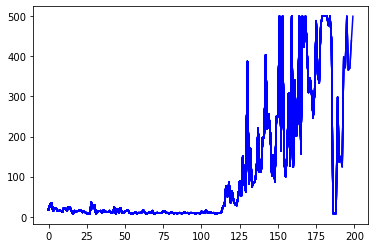

In [6]:
import time

# We now start the main function, that means we train the agent...
bNotificationStarted = False

# Learning factors...
EPISODES = 200
discount_factor = 0.99
learning_rate = 0.001
epsilon = 1.0
epsilon_decay = 0.999
epsilon_min = 0.01
batch_size = 64
train_start = 1000

# empty replay memory using deque
memory = deque(maxlen=2000)

start = time.time()
main()
ende = time.time()
print("\n\nLaufzeit: " + '{:5.3f}s'.format(ende-start))
model.save_weights("./cartpole_dqn_final.h5")